# Piazza Data Collection & Analysis
Zehua Li
April 2017

This notebook looks at the timing distributions of the question and answer generation on piazza.

In [1]:
# python setup

% matplotlib inline

from piazza_api.rpc import PiazzaRPC
from datetime import datetime
import time

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

## Piazza connection using API

In [2]:
#p = PiazzaRPC(classcode) # course
#p.user_login(username, password) # login

## Functions

In [3]:
def to_time(t): # convert to unix timestamp (in seconds)
    fmt = '%Y-%m-%dT%H:%M:%SZ'
    return time.mktime((datetime.strptime(t, fmt)).timetuple())

In [4]:
def to_hour(t): # convert to unix timestamp (in seconds)
    fmt = '%Y-%m-%dT%H:%M:%SZ'
    d = datetime.strptime(t, fmt)
    h = d.hour*3600. + d.minute*60. + d.second
    return h

In [5]:
def diff_time(t1, t2):# subtract
    return int(abs(t1-t2))

In [6]:
def get_timing(cid,tag = None,only_ct = True):
    try:
        post = p.content_get(cid)
        if (post["type"] != "question"):
            return None # if not a question, ignore
        if (tag is not None):
            if(not set(tag).isdisjoint(post["tags"])):
                return None # if does not meet the requested tag, ignore
        c_time = to_time(post['created']) # time thread is created
        s_time = -1 # time thread is resolved by student, -1 if never
        i_time = -1 # time thread is resolved by instructor, -1 if never
        if (not only_ct):
            for x in post["children"]:
                if (x["type"]=="s_answer"):
                    s_time = to_time(x['created'])
                if (x["type"]=="i_answer"):
                    i_time = to_time(x['created'])
        return [c_time,s_time,i_time]
    except:
        pass # if post does not exist, ignore

In [246]:
def get_daily_timing(cid,tag = None):
    try:
        if (p.content_get(cid)["type"] != "question"):
            return None # if not a question, ignore
        if (tag is not None):
            if(tag not in p.content_get(cid)["tags"]):
                return None # if does not meet the requested tag, ignore
        c_time = to_hour(p.content_get(cid)['created'])
        return [c_time]
    except:
        pass # if post does not exist, ignore

In [8]:
def get_latency(cid,tag = None):
    try:
        if (p.content_get(cid)["type"] != "question"):
            return None # if not a question, ignore
        if (tag is not None):
            if(tag not in p.content_get(cid)["tags"]):
                return None # if does not meet the requested tag, ignore
        c_time = to_time(p.content_get(cid)['created']) # time thread is created
        s_time = -1 # time thread is resolved by student, -1 if never
        i_time = -1 # time thread is resolved by instructor, -1 if never
        for x in p.content_get(cid)["children"]:
            if (x["type"]=="s_answer"):
                s_time = diff_time(to_time(x['created']),c_time)
            if (x["type"]=="i_answer"):
                i_time = diff_time(to_time(x['created']),c_time)
        return [c_time,s_time,i_time]
    except:
        pass # if post does not exist, ignore

## Post types

In [22]:
quiz = ["quiz1","quiz2","quiz3","quiz4","quiz5"]
test = ["midterm_exam1","midterm_exam2"]
mp = ["pointers_gone_wild","vector","text_editor","shell","malloc","password_cracker","parallel_make","mapreduce","mp","networking_nightmare"]
lab = ["know_your_tools","extreme_edge_cases","utilities_unleased","mini_valgrind","ideal_indirection","mad_mad_access_pattern","finding_filesystems","chatroom","scheduler","super_linux_kernel","lab","teaching_threads","splendid_synchronization","deadlocked_diners","pied_piper"]

## Quiz Posts

In [23]:
[idx_start,idx_end,tag] = [0,3300,quiz]

t_c_arr = []
t_last = 0

start_time = time.time()

for i in range(idx_start,idx_end):
    t_cur = get_timing(i,tag)
    if (t_cur != None):
        if (t_last == 0):
            t_last = t_cur[0]
        t_c_arr.append(t_cur[0]-t_last)
        t_last = t_cur[0]

print("--- %s seconds ---\n" % (time.time() - start_time))

--- 887.3238580226898 seconds ---



In [24]:
arr = [x/3600. for x in t_c_arr]
print(*arr, sep=' ')

0.0 65.95138888888889 3.9677777777777776 0.6797222222222222 3.3430555555555554 1.9052777777777778 6.671111111111111 5.499722222222222 2.8175 1.38 1.4905555555555556 8.5 10.645 1.6208333333333333 1.9938888888888888 0.7977777777777778 0.15222222222222223 2.8219444444444446 0.09777777777777778 0.8416666666666667 0.5577777777777778 0.0325 0.0077777777777777776 0.1025 0.44333333333333336 0.16444444444444445 0.30944444444444447 0.4336111111111111 0.7061111111111111 0.9238888888888889 0.013333333333333334 1.2275 12.339722222222223 1.0266666666666666 1.0291666666666666 3.9505555555555554 0.03194444444444444 0.9805555555555555 0.22166666666666668 1.1177777777777778 0.0175 0.6925 0.9988888888888889 0.003611111111111111 0.10305555555555555 0.2111111111111111 0.7616666666666667 0.09694444444444444 0.1725 7.680555555555555 5.014722222222222 1.2025 0.8025 0.03611111111111111 2.4316666666666666 0.5061111111111111 1.331388888888889 0.9322222222222222 0.2980555555555556 0.385 0.2797222222222222 1.44083

In [25]:
sum(arr)

2475.8130555555576

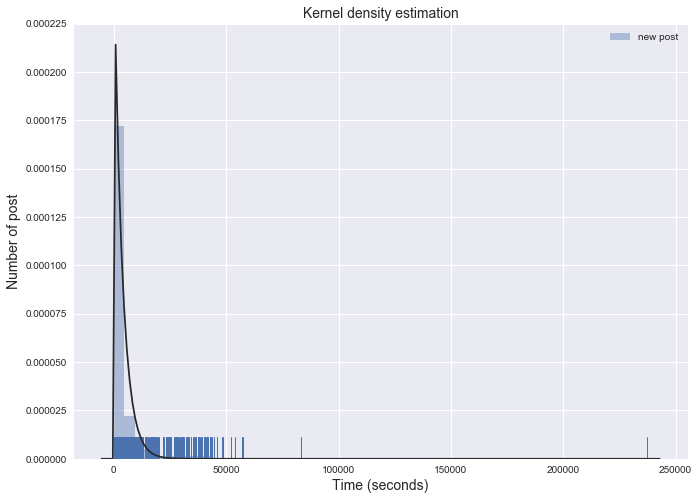

In [26]:
fig, ax = plt.subplots(figsize=(11,8))
sns.distplot(t_c_arr, kde=False, rug=True, ax=ax, fit=stats.expon, label = "new post")
ax.set_xlabel('Time (seconds)', fontsize=14)
ax.set_ylabel('Number of post', fontsize=14)
ax.set_title('Kernel density estimation', fontsize=14)
plt.legend();

In [29]:
## Test Posts

In [27]:
[idx_start,idx_end,tag] = [0,3300,test]

t_c_arr = []
t_last = 0

start_time = time.time()

for i in range(idx_start,idx_end):
    t_cur = get_timing(i,tag)
    if (t_cur != None):
        if (t_last == 0):
            t_last = t_cur[0]
        t_c_arr.append(t_cur[0]-t_last)
        t_last = t_cur[0]

print("--- %s seconds ---\n" % (time.time() - start_time))

--- 829.8759009838104 seconds ---



In [30]:
test_arr = [x/3600. for x in t_c_arr]
print(*test_arr, sep=' ')

0.0 65.95138888888889 3.9677777777777776 0.6797222222222222 3.3430555555555554 1.9052777777777778 6.671111111111111 5.499722222222222 2.8175 1.38 9.990555555555556 10.645 1.6208333333333333 1.9938888888888888 0.7977777777777778 0.15222222222222223 2.8219444444444446 0.09777777777777778 0.8416666666666667 0.5577777777777778 0.0325 0.0077777777777777776 0.1025 0.44333333333333336 0.16444444444444445 0.30944444444444447 0.4336111111111111 0.7061111111111111 0.9238888888888889 0.013333333333333334 1.2275 12.339722222222223 1.0266666666666666 1.0291666666666666 3.9505555555555554 0.03194444444444444 0.9805555555555555 0.22166666666666668 1.1177777777777778 0.0175 0.6925 0.9988888888888889 0.003611111111111111 0.10305555555555555 0.2111111111111111 0.7616666666666667 0.09694444444444444 0.1725 7.680555555555555 5.014722222222222 1.2025 0.8025 0.03611111111111111 2.4316666666666666 0.5061111111111111 1.331388888888889 0.9322222222222222 0.2980555555555556 0.385 0.2797222222222222 1.4408333333

In [ ]:
## Lab

In [31]:
[idx_start,idx_end,tag] = [0,3300,lab]

t_c_arr = []
t_last = 0

start_time = time.time()

for i in range(idx_start,idx_end):
    t_cur = get_timing(i,tag)
    if (t_cur != None):
        if (t_last == 0):
            t_last = t_cur[0]
        t_c_arr.append(t_cur[0]-t_last)
        t_last = t_cur[0]

print("--- %s seconds ---\n" % (time.time() - start_time))

--- 784.3442509174347 seconds ---



In [32]:
lab_arr = [x/3600. for x in t_c_arr]
print(*test_arr, sep=' ')

0.0 65.95138888888889 3.9677777777777776 0.6797222222222222 3.3430555555555554 1.9052777777777778 6.671111111111111 5.499722222222222 2.8175 1.38 9.990555555555556 10.645 1.6208333333333333 1.9938888888888888 0.7977777777777778 0.15222222222222223 2.8219444444444446 0.09777777777777778 0.8416666666666667 0.5577777777777778 0.0325 0.0077777777777777776 0.1025 0.44333333333333336 0.16444444444444445 0.30944444444444447 0.4336111111111111 0.7061111111111111 0.9238888888888889 0.013333333333333334 1.2275 12.339722222222223 1.0266666666666666 1.0291666666666666 3.9505555555555554 0.03194444444444444 0.9805555555555555 0.22166666666666668 1.1177777777777778 0.0175 0.6925 0.9988888888888889 0.003611111111111111 0.10305555555555555 0.2111111111111111 0.7616666666666667 0.09694444444444444 0.1725 7.680555555555555 5.014722222222222 1.2025 0.8025 0.03611111111111111 2.4316666666666666 0.5061111111111111 1.331388888888889 0.9322222222222222 0.2980555555555556 0.385 0.2797222222222222 1.4408333333

In [ ]:
## mp

In [32]:
[idx_start,idx_end,tag] = [0,3300,None]

t_c_arr = []
t_last = 0

start_time = time.time()

for i in range(idx_start,idx_end):
    t_cur = get_timing(i,tag)
    if (t_cur != None):
        if (t_last == 0):
            t_last = t_cur[0]
        t_c_arr.append(t_cur[0]-t_last)
        t_last = t_cur[0]

print("--- %s seconds ---\n" % (time.time() - start_time))

--- 818.0313329696655 seconds ---



In [33]:
arr = [x/3600. for x in t_c_arr]
print(*arr, sep=' ')

0.0 65.95138888888889 3.9677777777777776 0.6797222222222222 3.3430555555555554 1.9052777777777778 6.671111111111111 5.499722222222222 2.8175 1.38 1.4905555555555556 8.5 10.645 1.6208333333333333 1.9938888888888888 0.7977777777777778 0.15222222222222223 2.8219444444444446 0.09777777777777778 0.8416666666666667 0.5577777777777778 0.0325 0.0077777777777777776 0.1025 0.44333333333333336 0.16444444444444445 0.30944444444444447 0.4336111111111111 0.7061111111111111 0.9238888888888889 0.013333333333333334 1.2275 12.339722222222223 1.0266666666666666 1.0291666666666666 3.9505555555555554 0.03194444444444444 0.9805555555555555 0.22166666666666668 1.1177777777777778 0.0175 0.6925 0.9988888888888889 0.003611111111111111 0.10305555555555555 0.2111111111111111 0.7616666666666667 0.09694444444444444 0.1725 7.680555555555555 5.014722222222222 1.2025 0.8025 0.03611111111111111 2.4316666666666666 0.5061111111111111 1.331388888888889 0.9322222222222222 0.2980555555555556 0.385 0.2797222222222222 1.44083

In [81]:
sum(arr)

2477.6736111111145

In [82]:
len(arr)

2435

## Instructor Answers

In [9]:
[idx_start,idx_end,tag] = [1,3200,None]

t_i_arr = []

start_time = time.time()

for i in range(idx_start,idx_end):
    t_cur = get_latency(i,tag)
    if (t_cur != None):
        if (t_cur[2] != -1):
            t_i_arr.append(t_cur[2])

print("--- %s seconds ---\n" % (time.time() - start_time))

--- 1441.891940832138 seconds ---



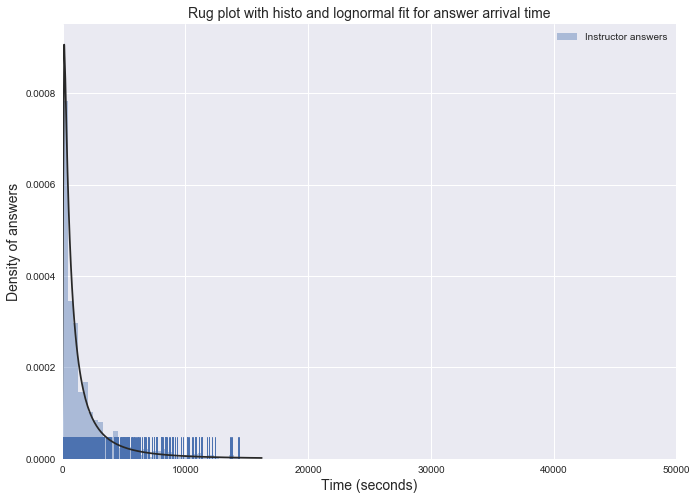

In [219]:
fig, ax = plt.subplots(figsize=(11,8))
sns.distplot(sorted(t_i_arr)[0:-100], kde=False, rug=True, ax=ax, fit=stats.lognorm, label = "Instructor answers")
ax.set_xlim([-10,50000])
ax.set_xlabel('Time (seconds)', fontsize=14)
ax.set_ylabel('Density of answers', fontsize=14)
ax.set_title('Rug plot with histo and lognormal fit for answer arrival time', fontsize=14)
plt.legend();

In [36]:
print(sorted(t_i_arr))

[16, 16, 18, 21, 22, 22, 23, 24, 25, 27, 28, 29, 30, 31, 31, 32, 32, 32, 32, 33, 34, 35, 36, 36, 36, 37, 38, 38, 38, 39, 39, 40, 41, 42, 42, 42, 43, 44, 44, 45, 45, 46, 46, 46, 47, 49, 49, 49, 49, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 52, 52, 52, 52, 54, 54, 54, 55, 56, 56, 57, 57, 58, 58, 58, 59, 59, 59, 59, 60, 60, 62, 63, 63, 63, 64, 64, 65, 65, 66, 67, 68, 69, 70, 71, 72, 72, 74, 74, 74, 74, 75, 75, 76, 76, 77, 77, 78, 78, 78, 79, 83, 83, 84, 85, 85, 86, 87, 87, 87, 88, 89, 89, 89, 90, 92, 93, 93, 93, 93, 95, 97, 97, 98, 98, 99, 99, 100, 102, 102, 102, 103, 104, 104, 104, 104, 106, 106, 106, 106, 106, 107, 107, 108, 108, 109, 110, 110, 110, 111, 112, 112, 112, 112, 112, 113, 116, 116, 117, 118, 121, 123, 124, 124, 125, 127, 128, 128, 131, 131, 132, 132, 134, 134, 136, 137, 139, 140, 140, 141, 141, 142, 142, 143, 143, 146, 146, 146, 147, 148, 149, 149, 149, 150, 150, 151, 151, 153, 154, 154, 154, 154, 157, 157, 158, 159, 159, 160, 160, 163, 163, 164, 165, 165, 168, 170, 170, 170, 

In [193]:
shape, loc, scale = stats.lognorm.fit(t_i_arr)
print(shape, loc, scale)

1.75503106835 4.72227752905 1169.54762114


In [166]:
stats.kstest(t_i_arr,'lognorm',args=(shape, loc, scale))

KstestResult(statistic=0.022334000978762508, pvalue=0.46730842970141123)

In [78]:
len(t_i_arr)

1444

In [80]:
1.36/np.sqrt(1444)

0.035789473684210531

In [168]:
l_ti = [np.log(x) for x in t_i_arr]

In [214]:
orig = [np.exp(x) for x in l_ti]

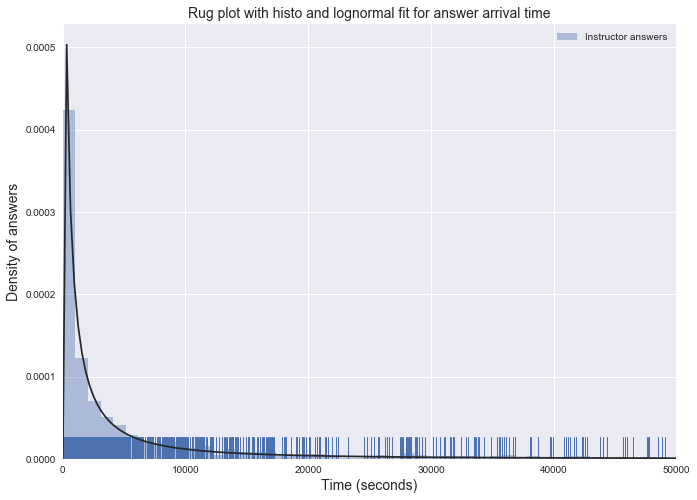

In [220]:
fig, ax = plt.subplots(figsize=(11,8))
sns.distplot(sorted(orig)[0:-100], kde=False, rug=True, ax=ax, fit=stats.lognorm, label = "Instructor answers")
ax.set_xlim([-10,50000])
ax.set_xlabel('Time (seconds)', fontsize=14)
ax.set_ylabel('Density of answers', fontsize=14)
ax.set_title('Rug plot with histo and lognormal fit for answer arrival time', fontsize=14)
plt.legend();

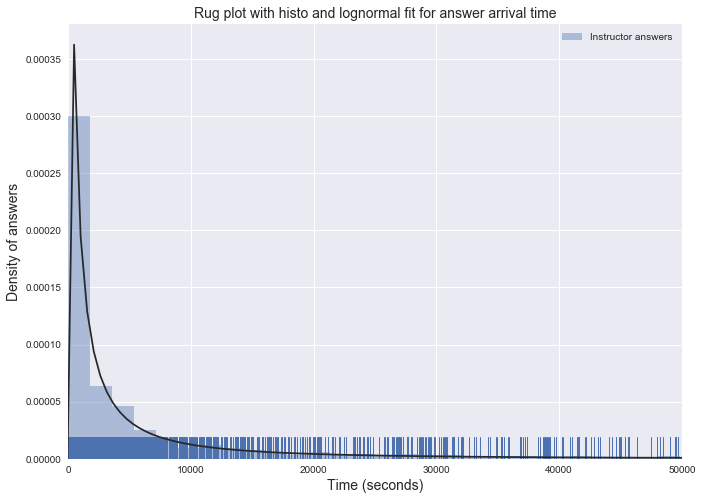

In [225]:
fig, ax = plt.subplots(figsize=(11,8))
sns.distplot(sorted(rv_orig)[0:-100], kde=False, rug=True, ax=ax, fit=stats.lognorm, label = "Instructor answers")
ax.set_xlim([-10,50000])
ax.set_xlabel('Time (seconds)', fontsize=14)
ax.set_ylabel('Density of answers', fontsize=14)
ax.set_title('Rug plot with histo and lognormal fit for answer arrival time', fontsize=14)
plt.legend();

In [222]:
shape, loc, scale = stats.lognorm.fit(orig)
print(shape, loc, scale)

2.23544803257 15.3449576115 1726.19704609


In [224]:
rv_orig = stats.lognorm.rvs(shape, loc, scale, 2500, random_state = 12345)

In [208]:
rv_orig_s = [x/3600. for x in rv_orig]

In [209]:
shape, loc, scale = stats.lognorm.fit(rv_orig_s)
print(shape, loc, scale)

2.23167174131 0.00419390260227 0.48443817024


In [242]:
stats.kstest(orig,'lognorm',args=(shape, loc, scale))

KstestResult(statistic=0.02233399717088777, pvalue=0.46730865000455807)

In [240]:
np.median(sorted(orig)[0:1100])

895.5

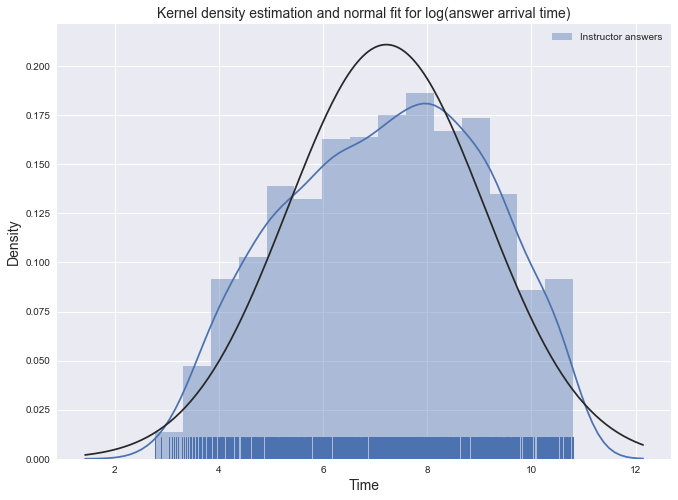

In [175]:
fig, ax = plt.subplots(figsize=(11,8))
sns.distplot(sorted(l_ti)[0:-100], kde=True, rug=True, ax=ax, fit=stats.norm, label = "Instructor answers")
#ax.set_xlim([-10,1000])
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_title('Kernel density estimation and normal fit for log(answer arrival time)', fontsize=14)
plt.legend();

In [180]:
i_a_rv = stats.lognorm.rvs(shape, loc, scale, 2500, random_state = 12345)

In [181]:
rv = [x/3600. for x in i_a_rv]
print(*rv, sep=' ')

0.0106073916049 0.643129362562 0.244800402584 0.935715049056 0.0369399426424 0.0469706825757 0.0326741645443 19.4158489361 0.0322333024075 0.173537802488 0.0578578513968 0.0114622825898 0.085566676793 0.459542962255 3.42435349334 0.710798140466 0.123767649682 4.84834514112 0.00788572828831 0.546683276487 0.381368150743 0.541513678178 0.0732977631589 5.14439165174 0.0102627339438 1.54541068686 0.0119551126214 2.88156863811 16.3210938957 2.30879359477 0.509026998651 3.15199117336 50.6952427773 0.0756064210898 0.0106302013469 0.065667611276 0.0209581078885 9.05182598047 1.8094656847 5.31591674561 0.338957349851 8.68466639536 0.256116400626 0.995414177109 0.374035526938 0.0785802998981 0.0846766961193 3.42714939678 0.424696002626 2.7104824296 1.86416456551 2.38113807415 1.37688901894 5.67795247352 0.100985975104 0.72015171694 0.332088244648 0.0120988640829 0.0549318271748 1.75612611416 0.112336167549 0.704956560405 1.56298248362 0.0859164663415 0.170525873741 4.21153074309 1.51236244416 1.

In [170]:
min(i_a_rv)

15.7439272041397

## Daily distribution (post)

In [247]:
[idx_start,idx_end] = [1,400]

t_h_arr = []
t_last = 0

start_time = time.time()

for i in range(idx_start,idx_end):
    t_cur = get_daily_timing(i)
    if (t_cur != None):
        t_h_arr.append(t_cur[0])

print("--- %s seconds ---\n" % (time.time() - start_time))

--- 109.19231915473938 seconds ---



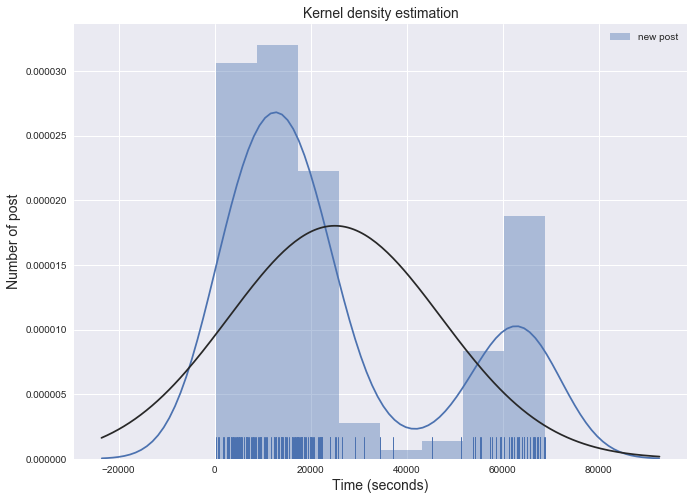

In [249]:
fig, ax = plt.subplots(figsize=(11,8))
sns.distplot(sorted(t_h_arr), kde=True, rug=True, ax=ax, fit=stats.norm, label = "new post")
#ax.set_xlim([-10,1000])
ax.set_xlabel('Time (seconds)', fontsize=14)
ax.set_ylabel('Number of post', fontsize=14)
ax.set_title('Kernel density estimation', fontsize=14)
plt.legend();

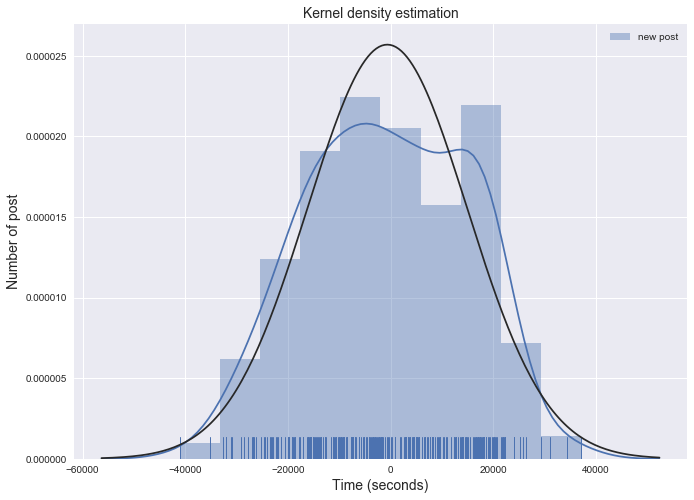

In [253]:
tharr = [x-86400 if x > 40000 else x for x in t_h_arr]
fig, ax = plt.subplots(figsize=(11,8))
sns.distplot(sorted(tharr), kde=True, rug=True, ax=ax, fit=stats.norm, label = "new post")
#ax.set_xlim([-10,1000])
ax.set_xlabel('Time (seconds)', fontsize=14)
ax.set_ylabel('Number of post', fontsize=14)
ax.set_title('Kernel density estimation', fontsize=14)
plt.legend();

In [128]:
def get_follow_up_latency(cid,tag = None):
    try:
        post = p.content_get(cid)
        if (post["type"] != "question"):
            return None # if not a question, ignore
        c_time = to_time(post['created']) # time thread is created
        f_time = []
        for x in post["change_log"]:
            if (x["type"]=="followup"):
                f_time.append(diff_time(to_time(x["when"]),c_time))
                break
        return f_time
    except:
        pass # if post does not exist, ignore

In [129]:
[idx_start,idx_end,tag] = [1,3200,None]

t_f_arr = []

start_time = time.time()

for i in range(idx_start,idx_end):
    t_cur = get_follow_up_latency(i,tag)
    if (t_cur != None):
        if (t_cur != []):
            t_f_arr.extend(t_cur)

print("--- %s seconds ---\n" % (time.time() - start_time))

--- 784.8739328384399 seconds ---



/Users/Clue/anaconda/envs/Design/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:2561: RuntimeWarning: divide by zero encountered in power
  return 1.0/Cinv * x**(a-1.0) * (1.0-x)**(b-1.0) / (1.0+z*x)**c


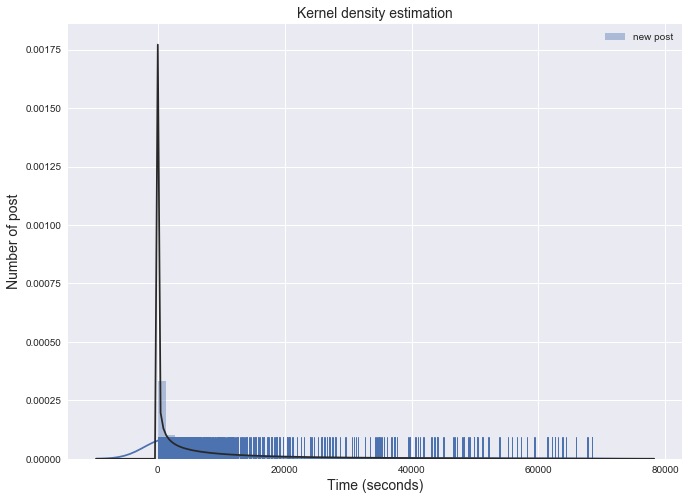

In [150]:
fig, ax = plt.subplots(figsize=(11,8))
sns.distplot(sorted(t_f_arr)[0:-100], kde=True, rug=True, ax=ax, fit=stats.gausshyper, label = "new post")
#ax.set_xlim([-10,1000])
ax.set_xlabel('Time (seconds)', fontsize=14)
ax.set_ylabel('Number of post', fontsize=14)
ax.set_title('Kernel density estimation', fontsize=14)
plt.legend();

In [159]:
c,loc, scale = stats.weibull_min.fit(t_f_arr)
print(c,loc, scale)

0.462929570385 10.0 7538.20209616


In [160]:
stats.kstest(t_f_arr,'weibull_min',args=(c,loc, scale))

KstestResult(statistic=0.095265444178973979, pvalue=1.7843482247315023e-10)

In [134]:
len(t_f_arr)

1269

In [135]:
1.36/np.sqrt(1633)

0.033654707161788588

In [106]:
def get_percent_answered_by_student_and_not_inst(cid,tag = None):
    try:
        post = p.content_get(cid)
        if (post["type"] != "question"):
            return None # if not a question, ignore
        c_time = to_time(post['created']) # time thread is created
        bs = 0
        bi = 0
        for x in post["children"]:
            if (x["type"]=="s_answer"):
                bs = 1
            if (x["type"]=="i_answer"):
                bi = 1
        return bs*(1-bi)
    except:
        pass # if post does not exist, ignore

In [110]:
[idx_start,idx_end,tag] = [1,3200,None]

b_s_arr = []

start_time = time.time()

for i in range(idx_start,idx_end):
    t_cur = get_percent_answered_by_student_and_not_inst(i,tag)
    if (t_cur != None):
        if (t_cur != []):
            b_s_arr.append(t_cur)

print("--- %s seconds ---\n" % (time.time() - start_time))

--- 850.1454589366913 seconds ---



In [111]:
sum(b_s_arr)/len(b_s_arr)

0.35002121340687314

## Student answer

In [182]:
[idx_start,idx_end,tag] = [1,3200,None]

t_i_arr = []

start_time = time.time()

for i in range(idx_start,idx_end):
    t_cur = get_latency(i,tag)
    if (t_cur != None):
        if (t_cur[1] != -1):
            t_i_arr.append(t_cur[1])

print("--- %s seconds ---\n" % (time.time() - start_time))

--- 1296.4062089920044 seconds ---



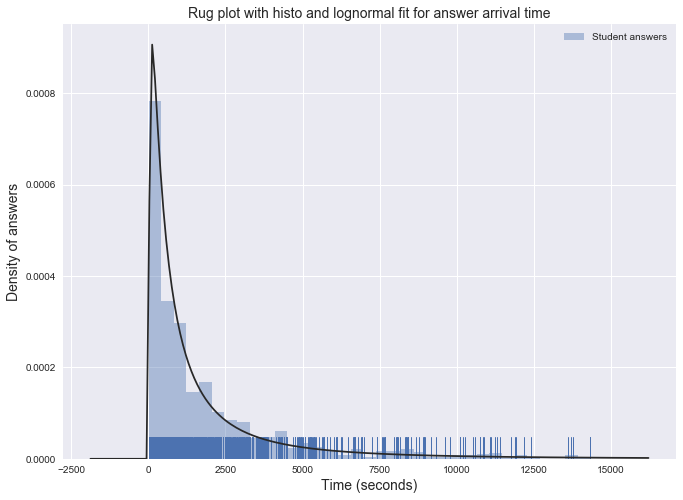

In [183]:
fig, ax = plt.subplots(figsize=(11,8))
sns.distplot(sorted(t_i_arr)[0:-100], kde=False, rug=True, ax=ax, fit=stats.lognorm, label = "Student answers")
#ax.set_xlim([-10,1000])
ax.set_xlabel('Time (seconds)', fontsize=14)
ax.set_ylabel('Density of answers', fontsize=14)
ax.set_title('Rug plot with histo and lognormal fit for answer arrival time', fontsize=14)
plt.legend();

In [184]:
shape, loc, scale = stats.lognorm.fit(t_i_arr)
print(shape, loc, scale)

1.75503106835 4.72227752905 1169.54762114


In [185]:
stats.kstest(t_i_arr,'lognorm',args=(shape, loc, scale))

KstestResult(statistic=0.031182828374802463, pvalue=0.22974685862538746)

In [186]:
len(t_i_arr)

1102

In [187]:
1.36/np.sqrt(1102)

0.040968315852756905

In [190]:
s_a_rv = stats.lognorm.rvs(shape, loc, scale, 2500, random_state = 12345)

In [191]:
rv = [x/3600. for x in i_a_rv]
print(*rv, sep=' ')

0.0106073916049 0.643129362562 0.244800402584 0.935715049056 0.0369399426424 0.0469706825757 0.0326741645443 19.4158489361 0.0322333024075 0.173537802488 0.0578578513968 0.0114622825898 0.085566676793 0.459542962255 3.42435349334 0.710798140466 0.123767649682 4.84834514112 0.00788572828831 0.546683276487 0.381368150743 0.541513678178 0.0732977631589 5.14439165174 0.0102627339438 1.54541068686 0.0119551126214 2.88156863811 16.3210938957 2.30879359477 0.509026998651 3.15199117336 50.6952427773 0.0756064210898 0.0106302013469 0.065667611276 0.0209581078885 9.05182598047 1.8094656847 5.31591674561 0.338957349851 8.68466639536 0.256116400626 0.995414177109 0.374035526938 0.0785802998981 0.0846766961193 3.42714939678 0.424696002626 2.7104824296 1.86416456551 2.38113807415 1.37688901894 5.67795247352 0.100985975104 0.72015171694 0.332088244648 0.0120988640829 0.0549318271748 1.75612611416 0.112336167549 0.704956560405 1.56298248362 0.0859164663415 0.170525873741 4.21153074309 1.51236244416 1.

In [204]:
shape, loc, scale = stats.lognorm.fit(rv)
print(shape, loc, scale)

2.22644133935 0.00446112912456 0.434959540292
